# Report 2
## Computational Neuroscience
## Computer Assignment 2
### Aref Afzali
### 610098014

In [1]:
%matplotlib notebook
import torch
import numpy as np

In [2]:
from cnsproject.network.neural_populations import ELIFPopulation, AELIFPopulation
from cnsproject.plotting.plotting import plotting
from cnsproject.utils import step_function, random_step_function
from cnsproject.network.monitors import Monitor

## Global Variables

$time$ parameter shows how often (seconds\*scale/dt) we want to run our neuron. $dt$ means with what resolution ($scale$) we want our seconds move forward.

In [3]:
time = 1500
dt = 1
scale = 100

## Description

The main part of each model is how compute the next potential. The computation formula for next potential is as follow:
<ol>
    <li>ELIF:</li>
    $U(t+\Delta) = U(t) - (\frac{\Delta}{\tau}).[(U(t) - U_{rest}) - \Delta_T.e^{\frac{U(t)-\theta_{rh}}{\Delta_T}} - R.I(t)]$
    <li>AELIF:</li>
    $W(t+\Delta) = W(t) + (\frac{\Delta}{\tau_w}).[a.(U(t) - U_{rest}) - W(t) + b.\tau_w.\sum_{t^f} \delta(t-t^f)]$
    $U(t+\Delta) = U(t) - (\frac{\Delta}{\tau_m}).[(U(t) - U_{rest}) - \Delta_T.e^{\frac{U(t)-\theta_{rh}}{\Delta_T}} + R.W - R.I(t)]$
</ol>


## Neuron Behavior

The next functions are simulation for a neuron based on ELIF and AELIF models. They return the neuron, current, a list of spikes, and a list of potentials.

In [4]:
def elif_single_neuron_time(
        time, dt, scale, step_size, I_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C, delta_t, threshold_rh, threshold_r = -55
    ):
    
    I = I_function(time, step_size, scale)
    neuron = ELIFPopulation(
            shape, spike_trace, additive_spike_trace, tau_s, trace_scale,
            is_inhibitory, learning, R, C, delta_t, threshold_rh, threshold_r
        )
    neuron.dt = dt
    monitor = Monitor(neuron, state_variables=["s", "u"])
    monitor.set_time_steps(time, dt)
    monitor.reset_state_variables()
    for i in range(len(I)):
        neuron.forward(I[i][0])
        monitor.record()
    return neuron, I, torch.transpose(monitor.get("s")*1, 0, 1), monitor.get("u")

def aelif_single_neuron_time(
        time, dt, scale, step_size, I_function, shape, spike_trace,
        additive_spike_trace, tau_s, trace_scale,
        is_inhibitory, learning, R, C, delta_t, tau_w, a, b, threshold_rh, threshold_r = -55
    ):
    
    I = I_function(time, step_size, scale)
    neuron = AELIFPopulation(
            shape, spike_trace, additive_spike_trace, tau_s, trace_scale,
            is_inhibitory, learning, R, C, delta_t, tau_w, a, b, threshold_rh, threshold_r
        )
    neuron.dt = dt
    monitor = Monitor(neuron, state_variables=["s", "u"])
    monitor.set_time_steps(time, dt)
    monitor.reset_state_variables()
    for i in range(len(I)):
        neuron.forward(I[i][0])
        monitor.record()
    return neuron, I, torch.transpose(monitor.get("s")*1, 0, 1), monitor.get("u")

## Exponential Leaky Integrate and Fire Model

The default of the parameters of a neuron is as follow:

<IPython.core.display.Javascript object>


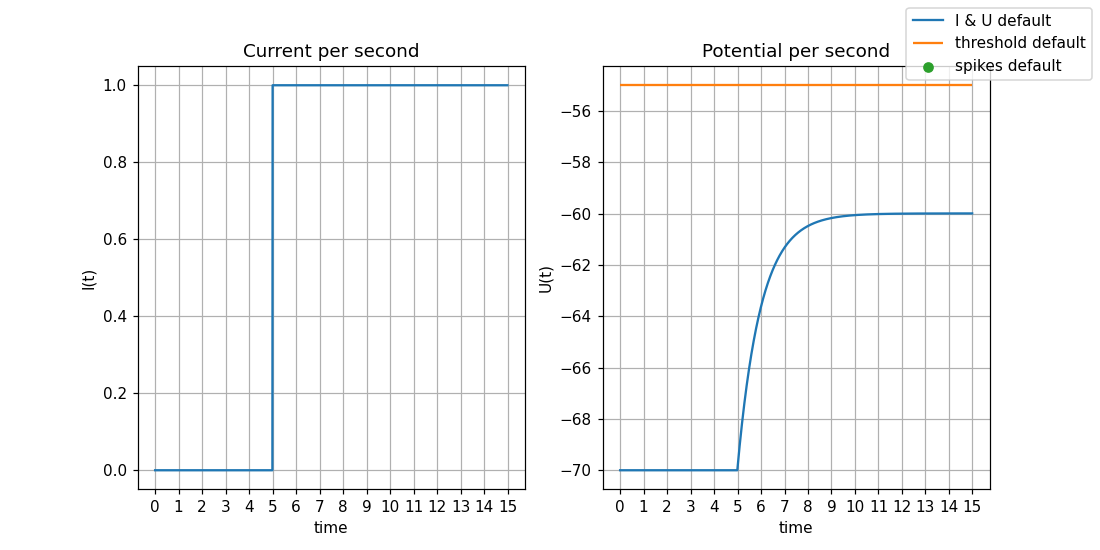

CPU times: user 440 ms, sys: 12.3 ms, total: 452 ms
Wall time: 448 ms


In [5]:
%%time
time = 1500
scale = 100
plot = plotting()
neuron, I, s, u = elif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10, delta_t = 1,
        threshold_rh = -55, threshold_r = 20
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "default")
plot.show()

The next cell is showing how the $\Delta_T$ affects on a neuron. By increasing $\Delta_T$, the growth rate of potential increases.

<IPython.core.display.Javascript object>


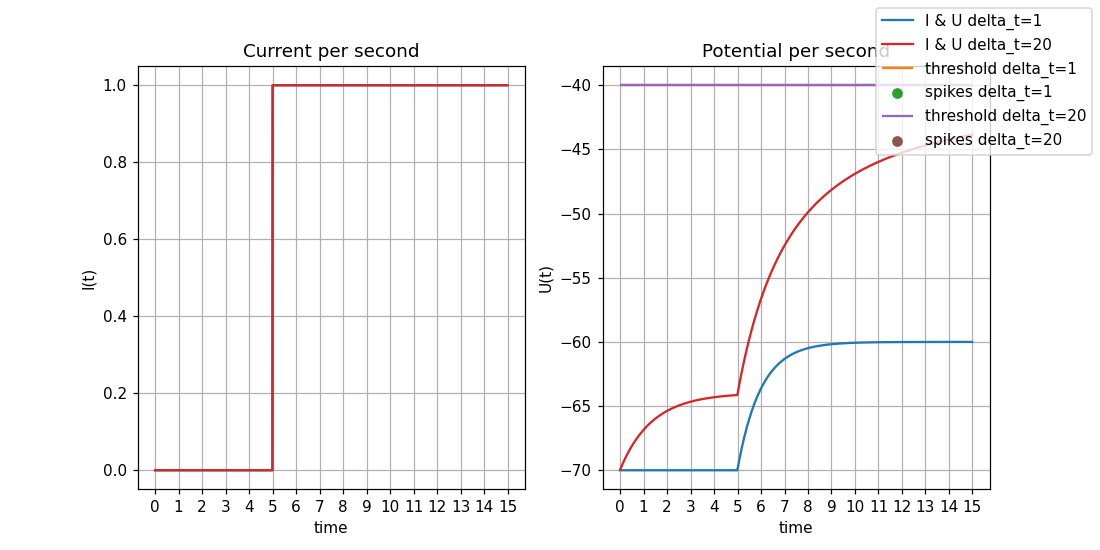

CPU times: user 844 ms, sys: 0 ns, total: 844 ms
Wall time: 840 ms


In [6]:
%%time
time = 1500
scale = 100

plot = plotting()
neuron, I, s, u = elif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10, delta_t = 1,
        threshold_rh = -40, threshold_r = 20
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "delta_t=1")

neuron, I, s, u = elif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10, delta_t = 20,
        threshold_rh = -40, threshold_r = 20
    )

plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "delta_t=20")
plot.show()

By decreasing $threshold$ we can see the neuron with the higher $\Delta_T$, will spike but the other one won't.

<IPython.core.display.Javascript object>


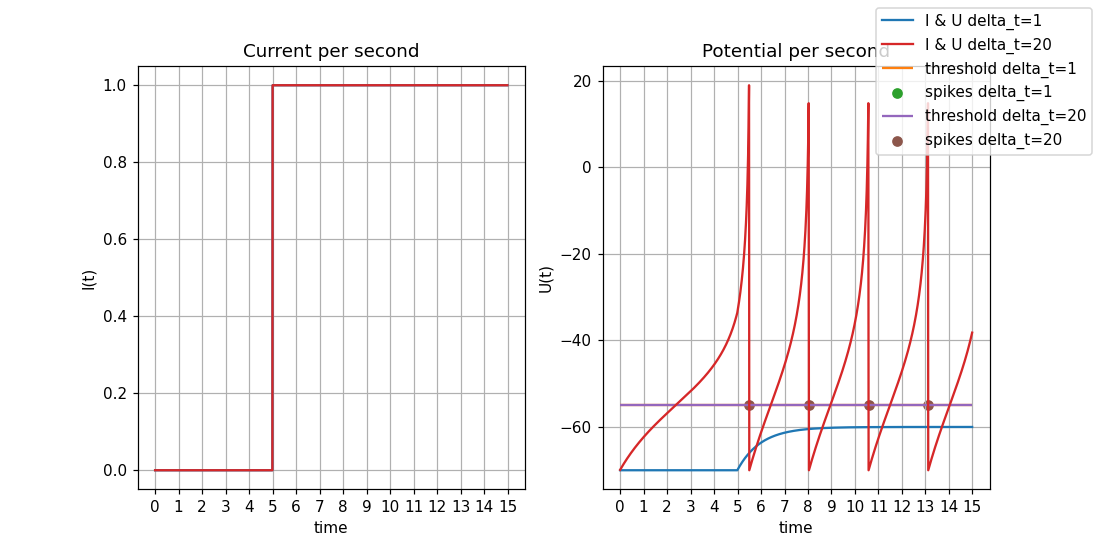

CPU times: user 793 ms, sys: 2.66 ms, total: 796 ms
Wall time: 822 ms


In [7]:
%%time
time = 1500
scale = 100

plot = plotting()
neuron, I, s, u = elif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10, delta_t = 1,
        threshold_rh = -55, threshold_r = 20
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "delta_t=1")

neuron, I, s, u = elif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10, delta_t = 20,
        threshold_rh = -55, threshold_r = 20
    )

plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "delta_t=20")
plot.show()

We can see a condition which both neuron with different $\Delta_T$ will spike.

<IPython.core.display.Javascript object>


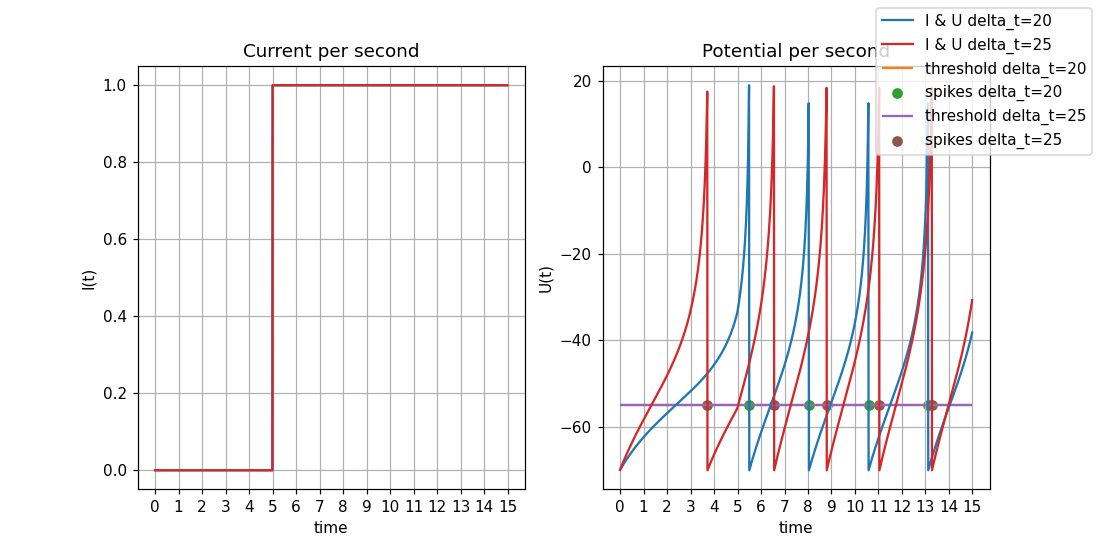

CPU times: user 799 ms, sys: 7.84 ms, total: 807 ms
Wall time: 806 ms


In [8]:
%%time
time = 1500
scale = 100

plot = plotting()
neuron, I, s, u = elif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10, delta_t = 20,
        threshold_rh = -55, threshold_r = 20
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "delta_t=20")

neuron, I, s, u = elif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10, delta_t = 25,
        threshold_rh = -55, threshold_r = 20
    )

plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "delta_t=25")
plot.show()

The next cell is showing how the $\theta_{rh}$ affects on a neuron. By decreasing $\theta_{rh}$, the rate of spikes increases.

<IPython.core.display.Javascript object>


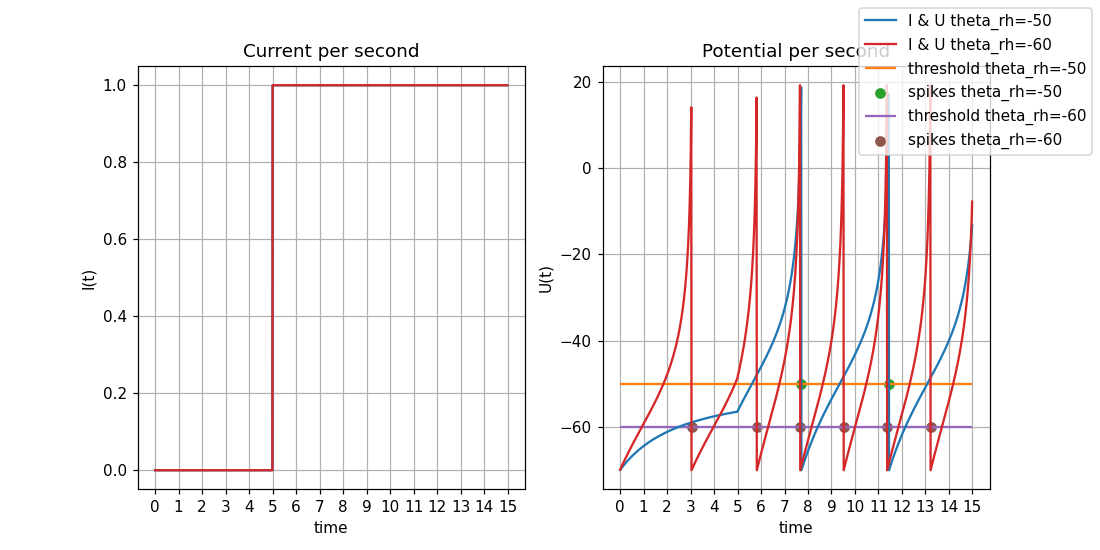

CPU times: user 850 ms, sys: 6.87 ms, total: 857 ms
Wall time: 869 ms


In [9]:
%%time
time = 1500
scale = 100

plot = plotting()
neuron, I, s, u = elif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10, delta_t = 20,
        threshold_rh = -50, threshold_r = 20
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "theta_rh=-50")

neuron, I, s, u = elif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10, delta_t = 20,
        threshold_rh = -60, threshold_r = 20
    )

plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "theta_rh=-60")
plot.show()

The next cell is showing how the $\theta_{r}$ (threshold for reseting the spike) affects on a neuron. By decreasing $\theta_{r}$, the rate of spikes increases. It will cause the spikes occure faster because the reseting is happening sooner.

<IPython.core.display.Javascript object>


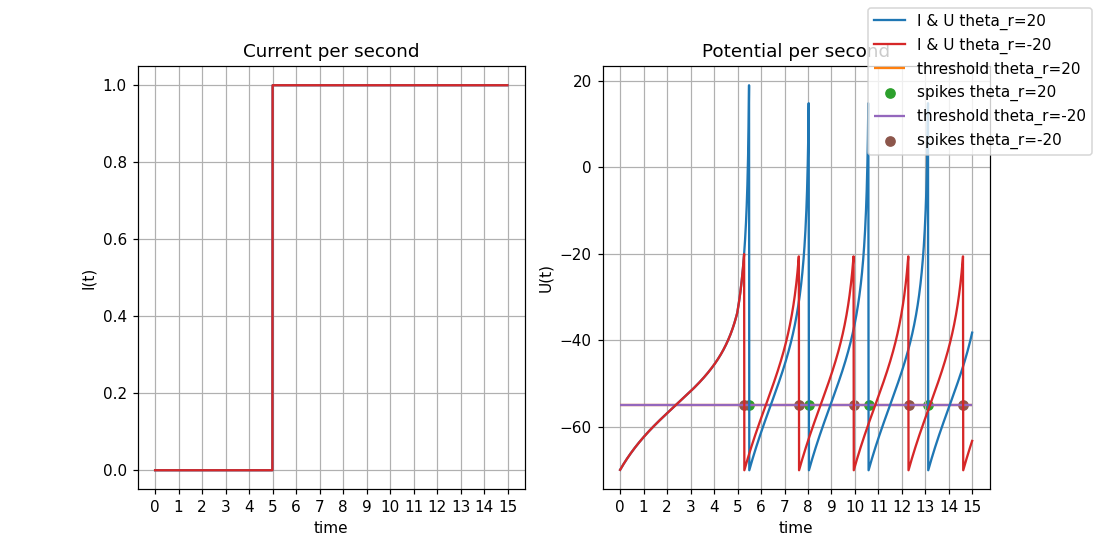

CPU times: user 779 ms, sys: 3.75 ms, total: 783 ms
Wall time: 780 ms


In [10]:
%%time
time = 1500
scale = 100

plot = plotting()
neuron, I, s, u = elif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10, delta_t = 20,
        threshold_rh = -55, threshold_r = 20
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "theta_r=20")

neuron, I, s, u = elif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10, delta_t = 20,
        threshold_rh = -55, threshold_r = -20
    )

plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "theta_r=-20")
plot.show()

Neuron with a random current as input:

<IPython.core.display.Javascript object>


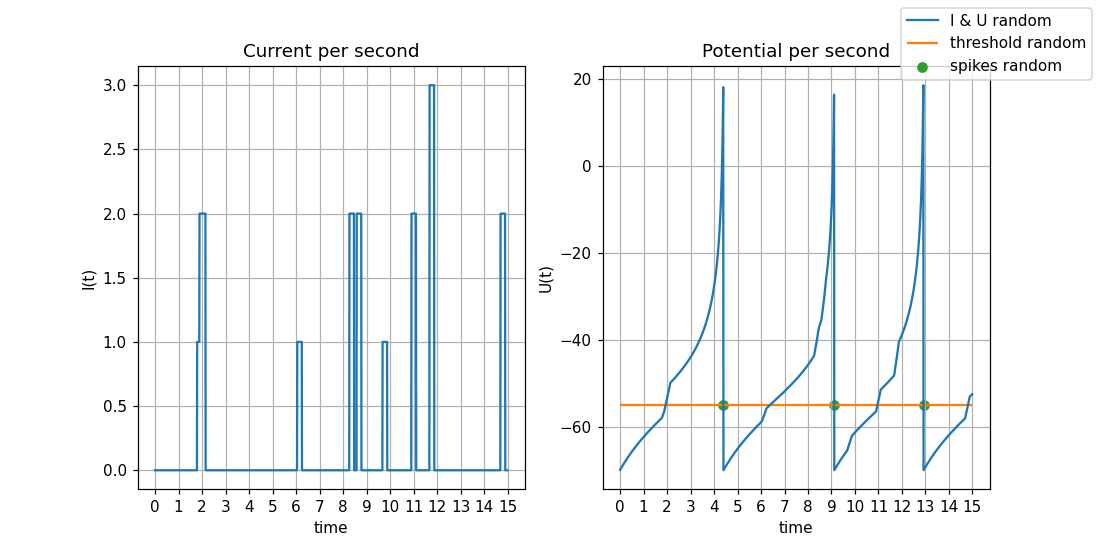

CPU times: user 565 ms, sys: 3.99 ms, total: 569 ms
Wall time: 566 ms


In [37]:
%%time
time = 1500
scale = 100

plot = plotting()
neuron, I, s, u = elif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 5,
        I_function = random_step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10, delta_t = 20,
        threshold_rh = -55, threshold_r = 20
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "random")
plot.show()

In the next cell, we are checking out the behavior of a neuron with different normal step function values. In the end, we plot the figure which shows the spikes frequency in each step function's value. This function has a live plotting.

<IPython.core.display.Javascript object>


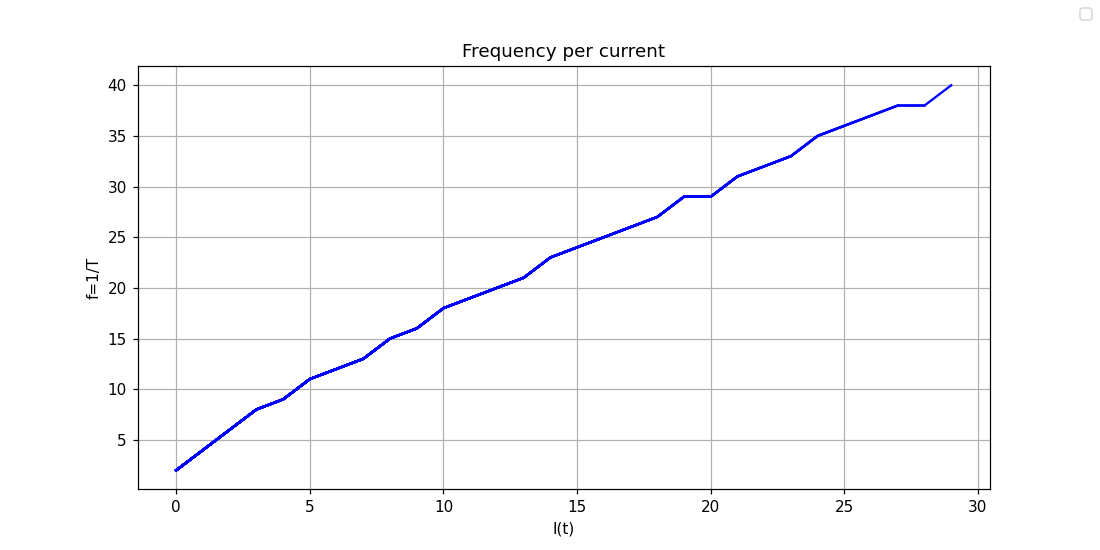

No handles with labels found to put in legend.


CPU times: user 11.2 s, sys: 81.4 ms, total: 11.3 s
Wall time: 11.6 s


In [14]:
%%time
plot.plot_fi_init()
spikes = []
for x in range(30):
    _, _, s, _ = elif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = x,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10, delta_t = 20,
        threshold_rh = -55, threshold_r = 20
    )
    spikes.append(s[0].sum())
    plot.plot_fi_update(spikes)

plot.show()

## Adaptive Exponential Leaky Integrate and Fire Model

The default of the parameters of a neuron is as follow:

<IPython.core.display.Javascript object>


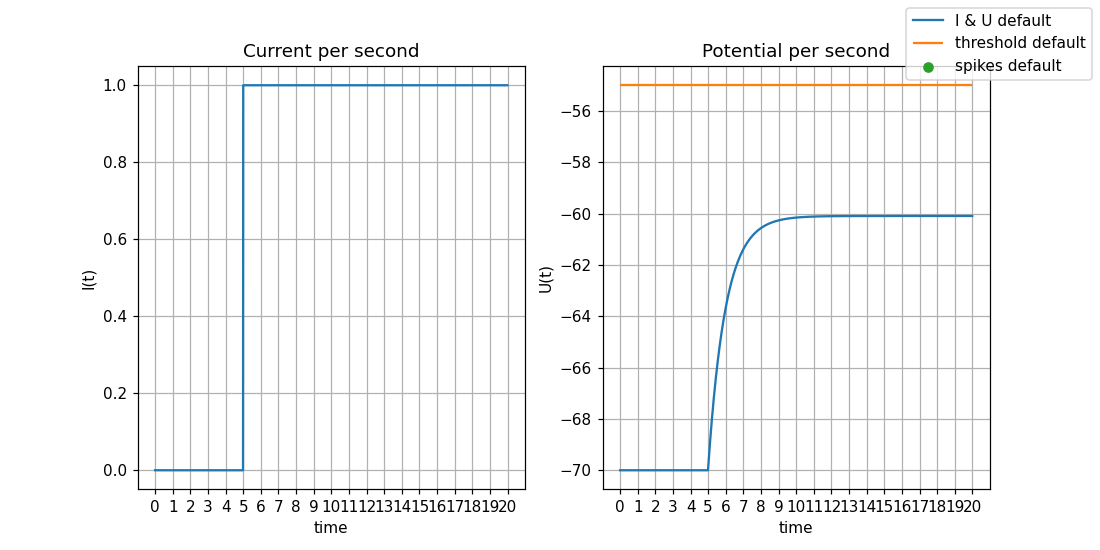

CPU times: user 699 ms, sys: 336 µs, total: 699 ms
Wall time: 695 ms


In [11]:
%%time
time = 2000
scale = 100

plot = plotting()

neuron, I, s, u = aelif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10,
        delta_t = 1, tau_w = 1, a = 0.001, b = 0.5,
        threshold_rh = -55, threshold_r = 0
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "default")
plot.show()

The next cell is showing how the $a$ affects on a neuron. By increasing $a$, the $W$ will increase so the growth rate of potential decreases.

<IPython.core.display.Javascript object>


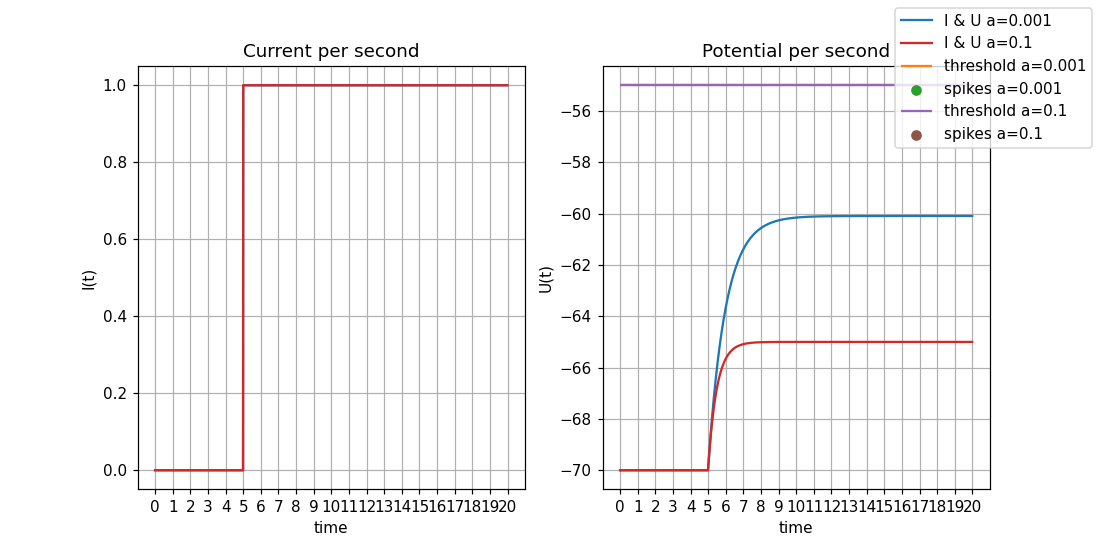

CPU times: user 1.37 s, sys: 6.68 ms, total: 1.38 s
Wall time: 1.38 s


In [12]:
%%time
time = 2000
scale = 100

plot = plotting()

neuron, I, s, u = aelif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10,
        delta_t = 1, tau_w = 1, a = 0.001, b = 0.5,
        threshold_rh = -55, threshold_r = 0
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "a=0.001")

neuron, I, s, u = aelif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10,
        delta_t = 1, tau_w = 1, a = 0.1, b = 0.5,
        threshold_rh = -55, threshold_r = 0
    )

plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "a=0.1")
plot.show()

With a higher current we can see the behavior of a adaptive ELIF neuron.

<IPython.core.display.Javascript object>


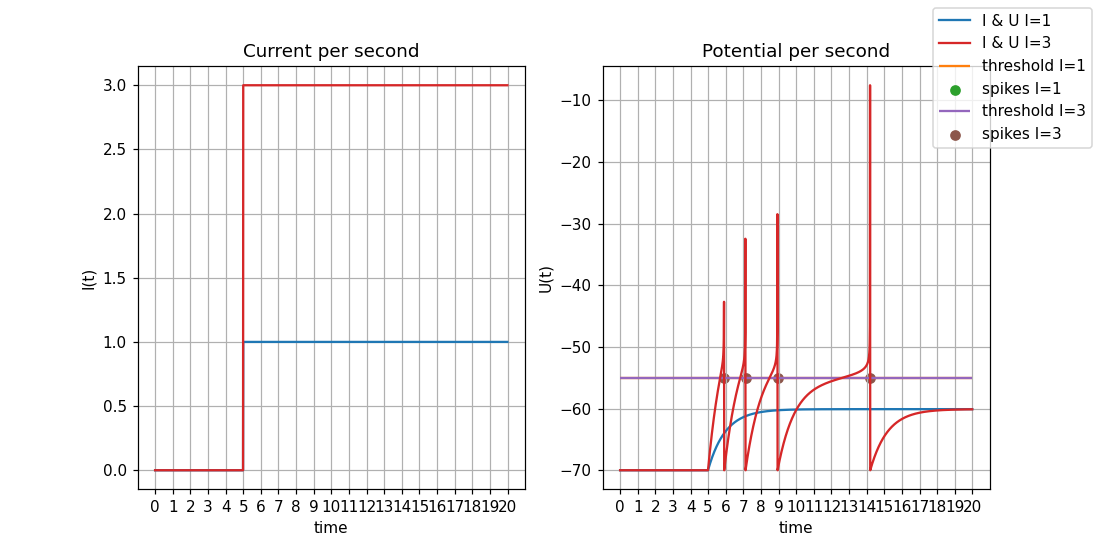

CPU times: user 1.28 s, sys: 3.34 ms, total: 1.29 s
Wall time: 1.29 s


In [13]:
%%time
time = 2000
scale = 100

plot = plotting()

neuron, I, s, u = aelif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 1,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10,
        delta_t = 1, tau_w = 1, a = 0.001, b = 0.5,
        threshold_rh = -55, threshold_r = 0
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "I=1")

neuron, I, s, u = aelif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 3,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10,
        delta_t = 1, tau_w = 1, a = 0.001, b = 0.5,
        threshold_rh = -55, threshold_r = 0
    )


plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "I=3")
plot.show()

The next cell is showing how the $b$ affects on a neuron. By decreasing $b$, the $W$ will decrease so the rate of adaptation decreases. It will cause more spikes occure in a duration of time.

<IPython.core.display.Javascript object>


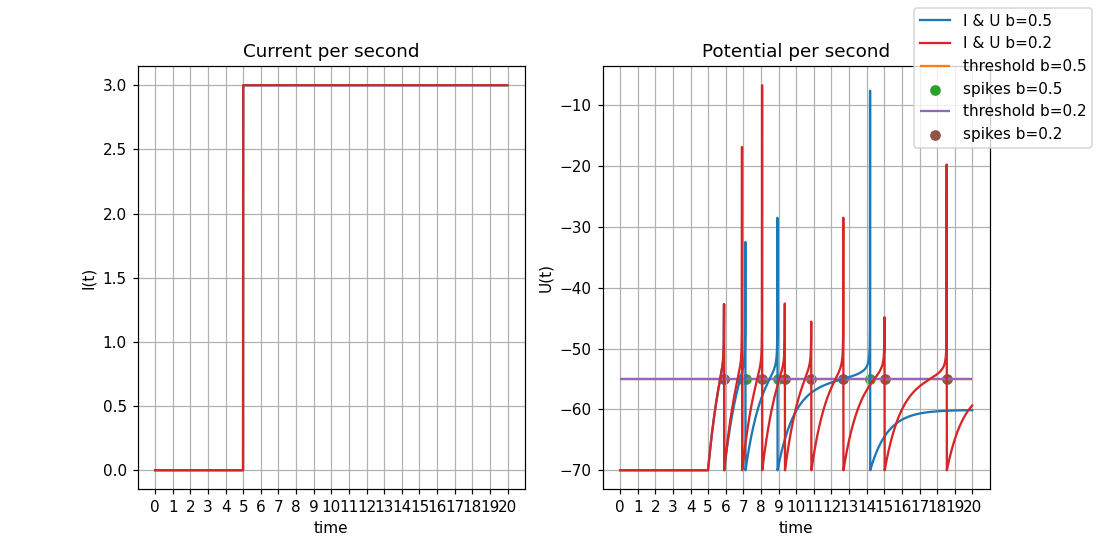

CPU times: user 1.27 s, sys: 6.64 ms, total: 1.28 s
Wall time: 1.28 s


In [14]:
%%time
time = 2000
scale = 100

plot = plotting()

neuron, I, s, u = aelif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 3,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10,
        delta_t = 1, tau_w = 1, a = 0.001, b = 0.5,
        threshold_rh = -55, threshold_r = 0
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "b=0.5")

neuron, I, s, u = aelif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 3,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10,
        delta_t = 1, tau_w = 1, a = 0.001, b = 0.2,
        threshold_rh = -55, threshold_r = 0
    )


plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "b=0.2")
plot.show()

The next cell is showing how the $\tau_w$ affects on a neuron. By increasing $\tau_w$, the $W$ will decrease so the rate of adaptation increases. It will cause less spikes occure in a duration of time.

<IPython.core.display.Javascript object>


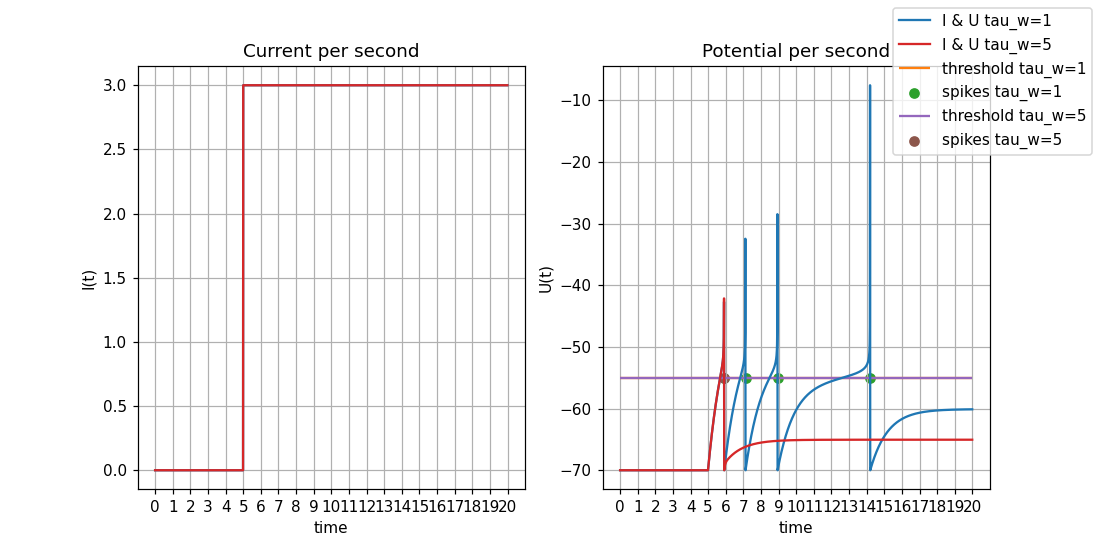

CPU times: user 1.38 s, sys: 15.8 ms, total: 1.39 s
Wall time: 1.39 s


In [15]:
%%time
time = 2000
scale = 100

plot = plotting()

neuron, I, s, u = aelif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 3,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10,
        delta_t = 1, tau_w = 1, a = 0.001, b = 0.5,
        threshold_rh = -55, threshold_r = 0
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "tau_w=1")

neuron, I, s, u = aelif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 3,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10,
        delta_t = 1, tau_w = 5, a = 0.001, b = 0.5,
        threshold_rh = -55, threshold_r = 0
    )

plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "tau_w=5")
plot.show()

Neuron with a random current as input:

<IPython.core.display.Javascript object>


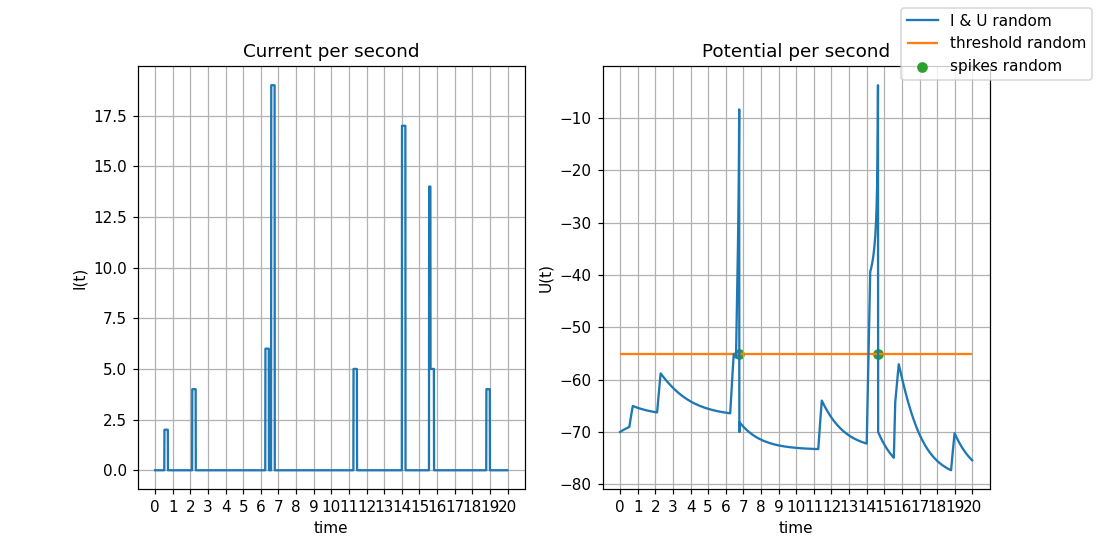

CPU times: user 707 ms, sys: 18.9 ms, total: 726 ms
Wall time: 732 ms


In [42]:
%%time
time = 2000
scale = 100

plot = plotting()

neuron, I, s, u = aelif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = 20,
        I_function = random_step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10,
        delta_t = 10, tau_w = 1, a = 0.001, b = 0.5,
        threshold_rh = -55, threshold_r = 0
    )

plot.plot_ut_it_init(time/scale)
plot.plot_ut_it_update(I, u, neuron.threshold_rh, s[0].nonzero(as_tuple=True)[0], "random")
plot.show()

In the next cell, we are checking out the behavior of a neuron with different normal step function values. In the end, we plot the figure which shows the spikes frequency in each step function's value. This function has a live plotting.

<IPython.core.display.Javascript object>


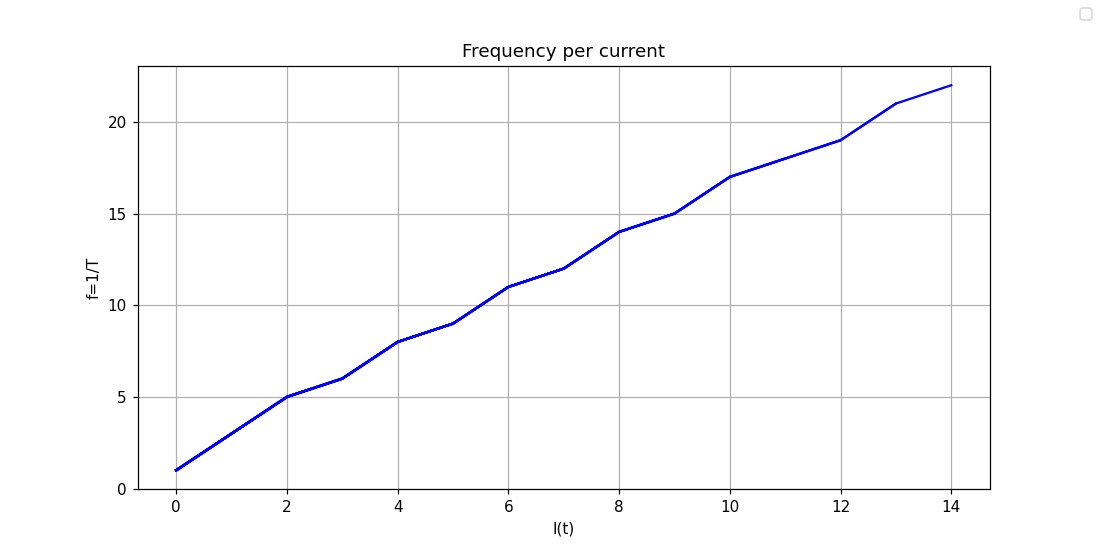

No handles with labels found to put in legend.


In [18]:
%%time
plot.plot_fi_init()
spikes = []
for x in range(15):
    _, _, s, _ = aelif_single_neuron_time(
        time = time, dt = 1, scale = scale, step_size = x,
        I_function = step_function, shape = (1,), spike_trace = True,
        additive_spike_trace = True, tau_s = 10., trace_scale = 1.,
        is_inhibitory = False, learning = False, R = 10, C = 10,
        delta_t = 20, tau_w = 1, a = 0.001, b = 0.5,
        threshold_rh = -55, threshold_r = 0
    )
    spikes.append(s[0].sum())
    plot.plot_fi_update(spikes)

plot.show()